# Flight Price Prediction Project

__Problem Statement__

The airline industry is considered as one of the most sophisticated industry in using complex pricing strategies. Nowadays, ticket prices can vary dynamically and significantly for the same flight, even for nearby seats. The ticket price of a specific flight can change up to 7 times a day. Customers are seeking to get the lowest price for their ticket, while airline companies are trying to keep their overall revenue as high as possible and maximize their profit. However, mismatches between available seats and passenger demand usually leads to either the customer paying more or the airlines company loosing revenue. Airlines companies are generally equipped with advanced tools and capabilities that enable them to control the pricing process. However, customers are also becoming more strategic with the development of various online tools to compare prices across various airline companies. In addition, competition between airlines makes the task of determining optimal pricing is hard for everyone.


## Importing Necessory Libraries

In [1]:
# data processing
import pandas as pd
# linear algebra
import numpy as np
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

#scaling
from sklearn.preprocessing import StandardScaler

#model selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score

#model evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load the data

In [2]:
#lets import the dataset
df = pd.read_csv("Flight_prices.csv")
df

,Unnamed: 0,Airline,Departure_time,Time_of_arrival,Duration,Source,Destination,Meal_availability,Number_of_stops,Price
0,0,Air Asia,12:40,20:15,7h 35m,New Delhi,Mumbai,No Meal Fare,1 Stop,"5,953"
1,1,Air Asia,11:55,20:15,8h 20m,New Delhi,Mumbai,No Meal Fare,1 Stop,"5,953"
2,2,Air Asia,16:15,06:20,14h 05m,New Delhi,Mumbai,No Meal Fare,1 Stop,"5,953"
3,3,Go First,18:50,20:45,1h 55m,New Delhi,Mumbai,No Meal Fare,Non Stop,"5,954"
4,4,Go First,09:05,11:05,2h 00m,New Delhi,Mumbai,No Meal Fare,Non Stop,"5,954"
...,...,...,...,...,...,...,...,...,...,...
5800,5800,Air India,08:55,08:20,23h 25m,Lucknow,Jaipur,No Meal Fare,1 Stop,"9,302"
5801,5801,Air India,08:55,09:20,24h 25m,Lucknow,Jaipur,No Meal Fare,2 Stop(s),"16,287"
5802,5802,Air India,14:45,09:20,18h 35m,Lucknow,Jaipur,No Meal Fare,2 Stop(s),"16,865"
5803,5803,Air India,08:55,09:20,24h 25m,Lucknow,Jaipur,No Meal Fare,2 Stop(s),"16,865"


__Feature Information__
1. **Airline:** Name of the airline
2. **Departure_time:** Time of deoarture of flight from the source location
3. **Time_of_arrival:** Time of arrival at destination
4. **Duration:** Total time of the journey from source to destination
5. **Source:** City names from where the flight is departing
6. **Destination:** Name of the city to which flight is arriving
7. **Meal_availability:** information about meal fare
8. **Number_of_stops:** Number of stops during the journey
9. **Price :** Flight fare 

In [3]:
#lets check the shape
df.shape

(5805, 10)

In [4]:
#checking info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5805 entries, 0 to 5804
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         5805 non-null   int64 
 1   Airline            5805 non-null   object
 2   Departure_time     5805 non-null   object
 3   Time_of_arrival    5805 non-null   object
 4   Duration           5805 non-null   object
 5   Source             5805 non-null   object
 6   Destination        5805 non-null   object
 7   Meal_availability  5805 non-null   object
 8   Number_of_stops    5805 non-null   object
 9   Price              5805 non-null   object
dtypes: int64(1), object(9)
memory usage: 453.6+ KB


We can see the dataset is having 5805 rows and 9 columns. And there are no missing values in our data set. All columns are with the data type as object, we will convert the numerical data to float data type.

In [5]:
#droping unwanted column
df.drop(columns = 'Unnamed: 0', inplace = True)

#lets check the unique values from airline column
df.Time_of_arrival.unique()

In [6]:
#lets check total stops
df["Meal_availability"].value_counts()

No Meal Fare    4252
Free Meal       1014
eCash 250        539
Name: Meal_availability, dtype: int64

Here in column Meal_availability is having some entries as 'eCash 250' , I will replace it with 'None'

In [7]:
df['Meal_availability'] = df['Meal_availability'].replace('eCash 250','None')

I will replace the that categorical values from Number_of_stops column to numeric data

In [8]:
df.Number_of_stops.replace({"Non Stop": 0,
                            "1 Stop": 1,
                            "2 Stop(s)": 2,
                            "3 Stop(s)": 3,
                            "4 Stop(s)": 4},
                           inplace = True)

## Duration

In [9]:
df.Duration

0        7h 35m
1        8h 20m
2       14h 05m
3        1h 55m
4        2h 00m
         ...   
5800    23h 25m
5801    24h 25m
5802    18h 35m
5803    24h 25m
5804    17h 50m
Name: Duration, Length: 5805, dtype: object

The column Duration is with object datatype by doing below operations to Duration column I will extract numerical value from it.

In [10]:
#Extracting numerical data using Duration 
df["hour"] = df.Duration.str.split('h').str.get(0)
df["min"] = df.Duration.str.split('h').str.get(1)
df["min"]=df["min"].str.split('m').str.get(0)

df["hour"]=df['hour'].astype('float')
df["min"]=df['min'].astype('float')

df["Duration"] = df["hour"] + (df["min"]/60)


In [11]:
#lets check the data set now
df.head()

,Airline,Departure_time,Time_of_arrival,Duration,Source,Destination,Meal_availability,Number_of_stops,Price,hour,min
0,Air Asia,12:40,20:15,7.583333,New Delhi,Mumbai,No Meal Fare,1,"5,953",7.0,35.0
1,Air Asia,11:55,20:15,8.333333,New Delhi,Mumbai,No Meal Fare,1,"5,953",8.0,20.0
2,Air Asia,16:15,06:20,14.083333,New Delhi,Mumbai,No Meal Fare,1,"5,953",14.0,5.0
3,Go First,18:50,20:45,1.916667,New Delhi,Mumbai,No Meal Fare,0,"5,954",1.0,55.0
4,Go First,09:05,11:05,2.000000,New Delhi,Mumbai,No Meal Fare,0,"5,954",2.0,0.0


Using hour and min column I have created Duration column with float values, now I am dropping hour and min columns

In [12]:
df.drop(columns = ["hour","min"], inplace = True)

## Price

In [13]:
df.Price

0        5,953
1        5,953
2        5,953
3        5,954
4        5,954
         ...  
5800     9,302
5801    16,287
5802    16,865
5803    16,865
5804    19,749
Name: Price, Length: 5805, dtype: object

In [14]:
#Lets convert data type of Price column to float
df['Price'] = df['Price'].str.replace(',','')
df['Price'] = df['Price'].astype('float')

## Departure_time & Time_of_arrival

In [15]:
df.Departure_time

0       12:40
1       11:55
2       16:15
3       18:50
4       09:05
        ...  
5800    08:55
5801    08:55
5802    14:45
5803    08:55
5804    15:30
Name: Departure_time, Length: 5805, dtype: object

Similar to Duration I will extract numric data from Departure_time and Time_of_arrival columns using below codes.

In [16]:
df["Dep_hour"] = pd.to_datetime(df.Departure_time, format="%H:%M").dt.hour
df["Dep_min"] = pd.to_datetime(df.Departure_time, format="%H:%M").dt.minute
df["Departure_time"]= df['Dep_hour']+(df['Dep_min']/60)
df.drop(columns = ['Dep_hour','Dep_min'],inplace=True)    

In [17]:
df.Time_of_arrival

0       20:15
1       20:15
2       06:20
3       20:45
4       11:05
        ...  
5800    08:20
5801    09:20
5802    09:20
5803    09:20
5804    09:20
Name: Time_of_arrival, Length: 5805, dtype: object

In [18]:
df["Arvl_hour"] = pd.to_datetime(df.Time_of_arrival, format="%H:%M").dt.hour
df["arvl_min"] = pd.to_datetime(df.Time_of_arrival, format="%H:%M").dt.minute
df["Time_of_arrival"]= df['Arvl_hour']+(df['arvl_min']/60)
df.drop(columns = ['Arvl_hour','arvl_min'],inplace=True)    

In [19]:
#lets check the data set now
df.head()

,Airline,Departure_time,Time_of_arrival,Duration,Source,Destination,Meal_availability,Number_of_stops,Price
0,Air Asia,12.666667,20.250000,7.583333,New Delhi,Mumbai,No Meal Fare,1,5953.0
1,Air Asia,11.916667,20.250000,8.333333,New Delhi,Mumbai,No Meal Fare,1,5953.0
2,Air Asia,16.250000,6.333333,14.083333,New Delhi,Mumbai,No Meal Fare,1,5953.0
3,Go First,18.833333,20.750000,1.916667,New Delhi,Mumbai,No Meal Fare,0,5954.0
4,Go First,9.083333,11.083333,2.000000,New Delhi,Mumbai,No Meal Fare,0,5954.0


In [20]:
#lets check the data type again
df.dtypes

Airline               object
Departure_time       float64
Time_of_arrival      float64
Duration             float64
Source                object
Destination           object
Meal_availability     object
Number_of_stops        int64
Price                float64
dtype: object

## EDA

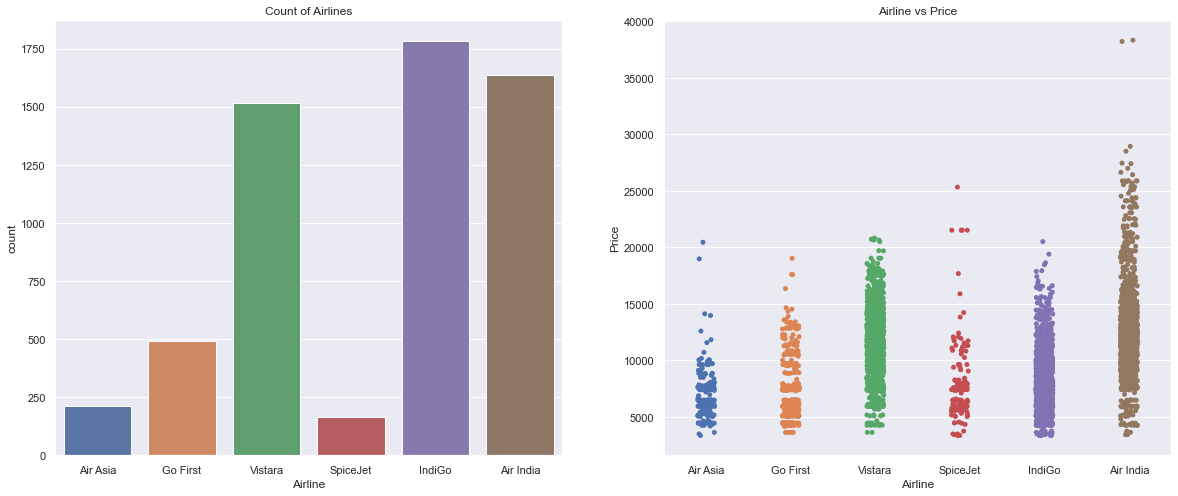

In [21]:
#lets check the count of airlines and check the relation between airline and Price
sns.set_theme()
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.countplot(df.Airline)
plt.title('Count of Airlines')

plt.subplot(1,2,2)
sns.stripplot(x='Airline',y='Price', data=df)
plt.title('Airline vs Price')

plt.show()

The count plot will tell us that there are more number of flights of Vistara, IndiGo and Air India than others. flights of Spice Jet are very less in numbers.

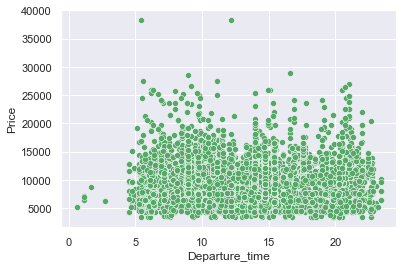

In [22]:
#check the relation between Departure_time and Price
sns.scatterplot(x='Departure_time',y='Price',data=df, color = 'g')
plt.show()

Above scatter plot is showing relationship between Departure time and flight prices. We can observe that there are very few flights departing in the early morning which are having lower price as well.

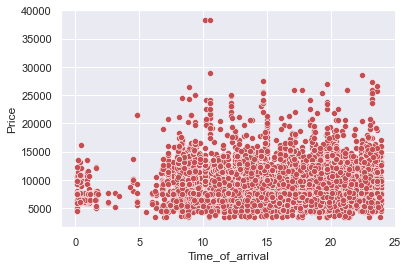

In [23]:
#check the relation between Time_of_arrival and Price
sns.scatterplot(x='Time_of_arrival',y='Price',data=df, color = 'r')
plt.show()

The above scatter plot is showing relation between Time of arrival and flight prices, which will tell us that very few number of flights are arriving in the early morning that is arrount 0 to 5 am. We can say the flight prices are not much dependent on the time of arrival.

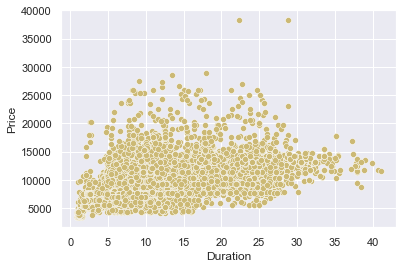

In [24]:
#check the relation between Duration and Price
sns.scatterplot(x='Duration',y='Price',data=df, color = 'y')
plt.show()

The above figure is representing the scatter plot of Duration vs Price. Looking at this figure we can say that there is some linear relation between price and duration. The price increaes with duration.

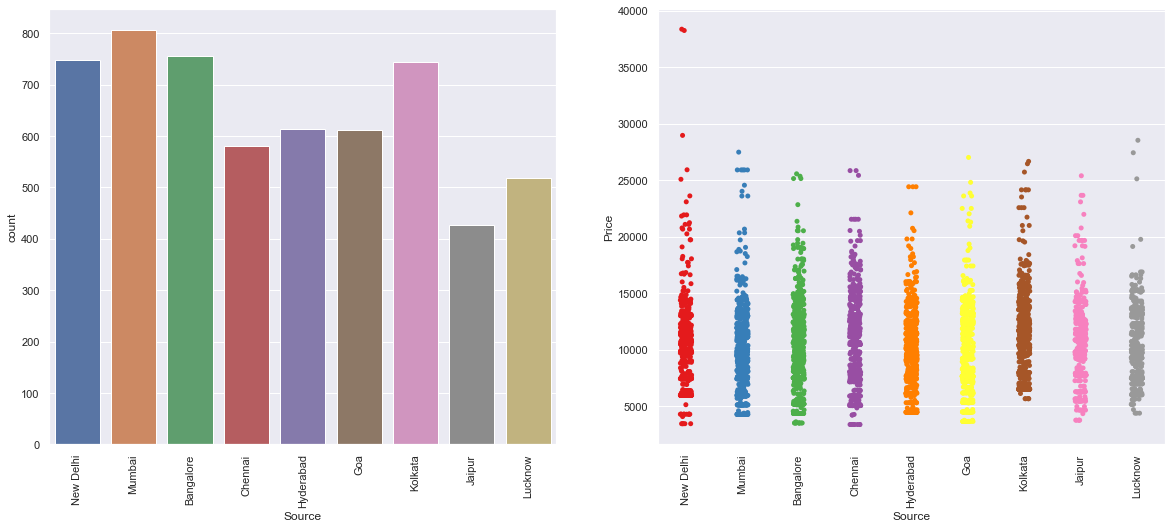

In [25]:
#Lets check the count and relation of Source with target variable
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.countplot(df.Source)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.stripplot(x='Source',y='Price',data=df, palette = 'Set1')
plt.xticks(rotation=90)
plt.show()

Here we are having more number of flights from New Delhi, Mumbai, Bangalore and Kolkata than other cities. Looking at the strip plot we can say flights from New Delhi are having some what higher prices than other cities.

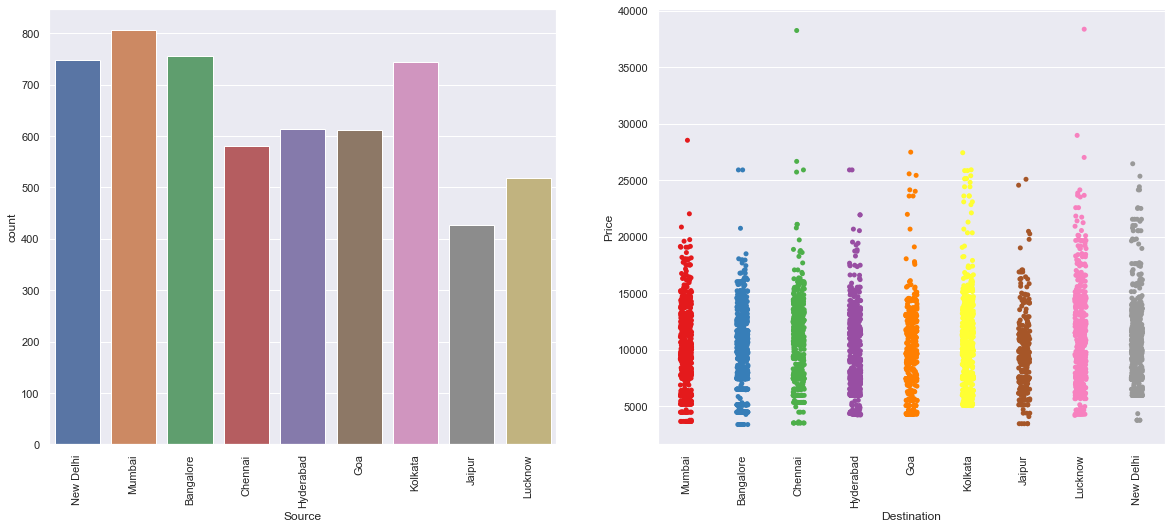

In [26]:
#Lets check the count and relation of Destination with target variable
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.countplot(df.Source)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.stripplot(x='Destination',y='Price',data=df, palette = 'Set1')
plt.xticks(rotation=90)
plt.show()

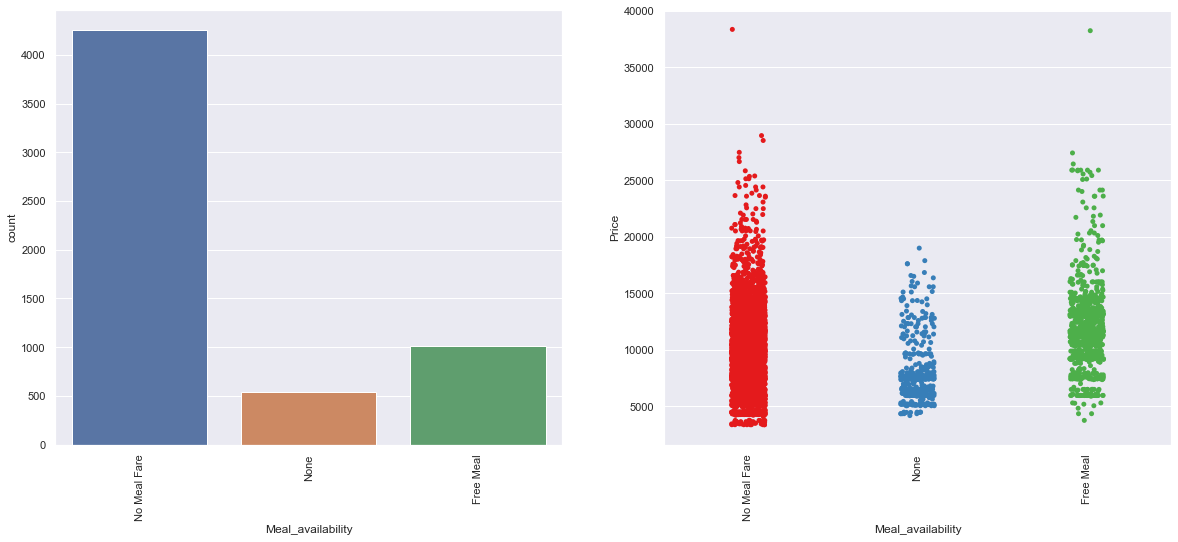

In [27]:
#lets check the relation between Meal_availability and prices
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.countplot(df.Meal_availability)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.stripplot(x='Meal_availability',y='Price',data=df, palette = 'Set1')
plt.xticks(rotation=90)
plt.show()

Looking at above plots we can conclude that more number of flights are not including Meal Fare, some of with providing free meal and rest few are with None category.

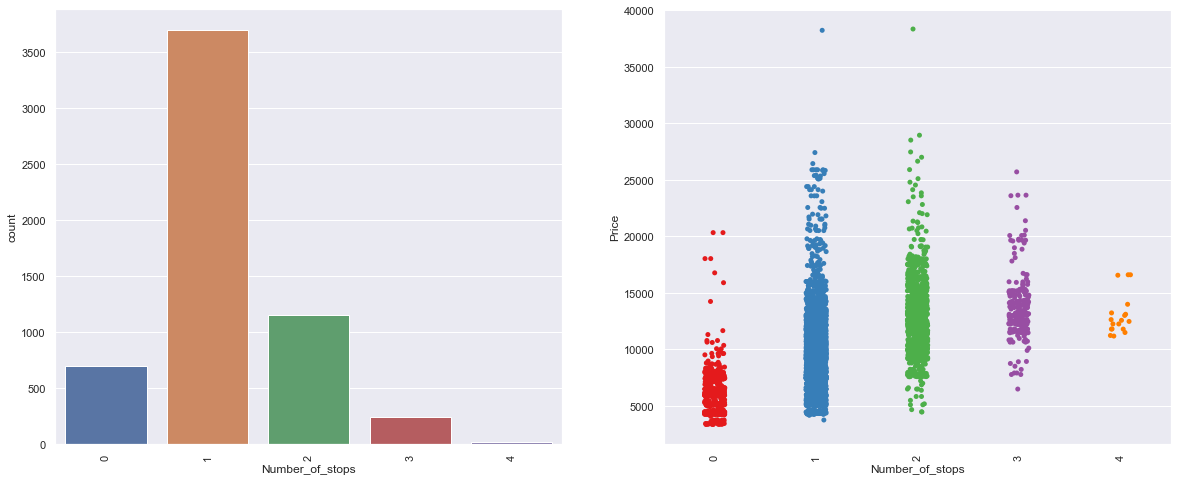

In [28]:
#lets check the count of stops and relation with price
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.countplot(df.Number_of_stops)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.stripplot(x='Number_of_stops',y='Price',data=df, palette = 'Set1')
plt.xticks(rotation=90)
plt.show()

The above count plot will tell us that most of the flights are with 1 stop and very few are with 3 and 4 stops during the Journy. We can see that the prices are increasing with the number of stops.

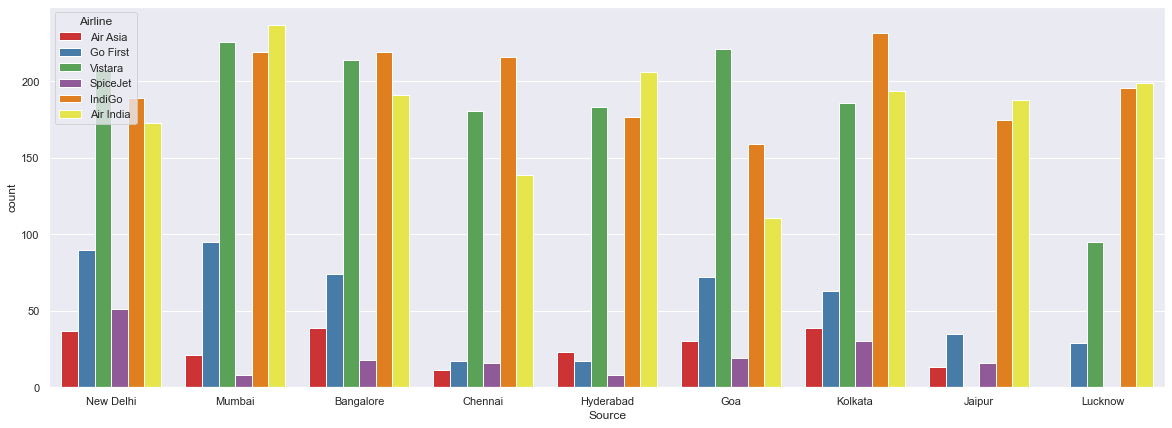

In [29]:
#Lets chcek the most popular flight region wise
plt.figure(figsize=(20,7))
sns.countplot(x = "Source", hue = "Airline", data = df, palette = 'Set1')
plt.show()

The above plot is showing the region wise count of airlines which will tell us that Jaipur is not having any flight of Vistara and the city Lucknow is not having any flights of Spice Jet. And all cities are having flights of IndiGo and Air India with higher count.

<Figure size 1440x576 with 0 Axes>

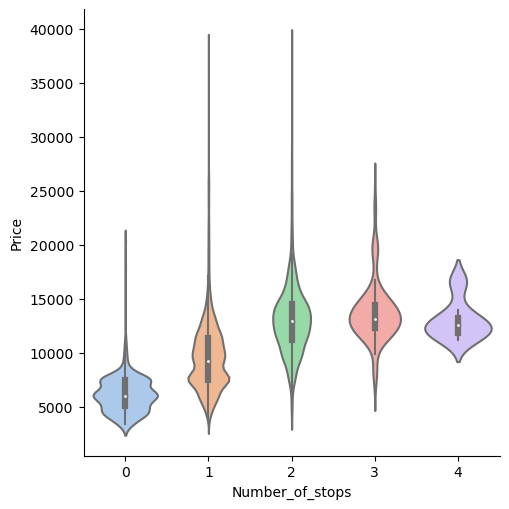

In [30]:
#lets check the relation between fuel_type, Gear_transmission and Mileage 
plt.figure(figsize=(20,8))
plt.style.use('default')
sns.catplot(x="Number_of_stops", y="Price",
            kind="violin", split=True,
            palette="pastel", data=df)
plt.show()

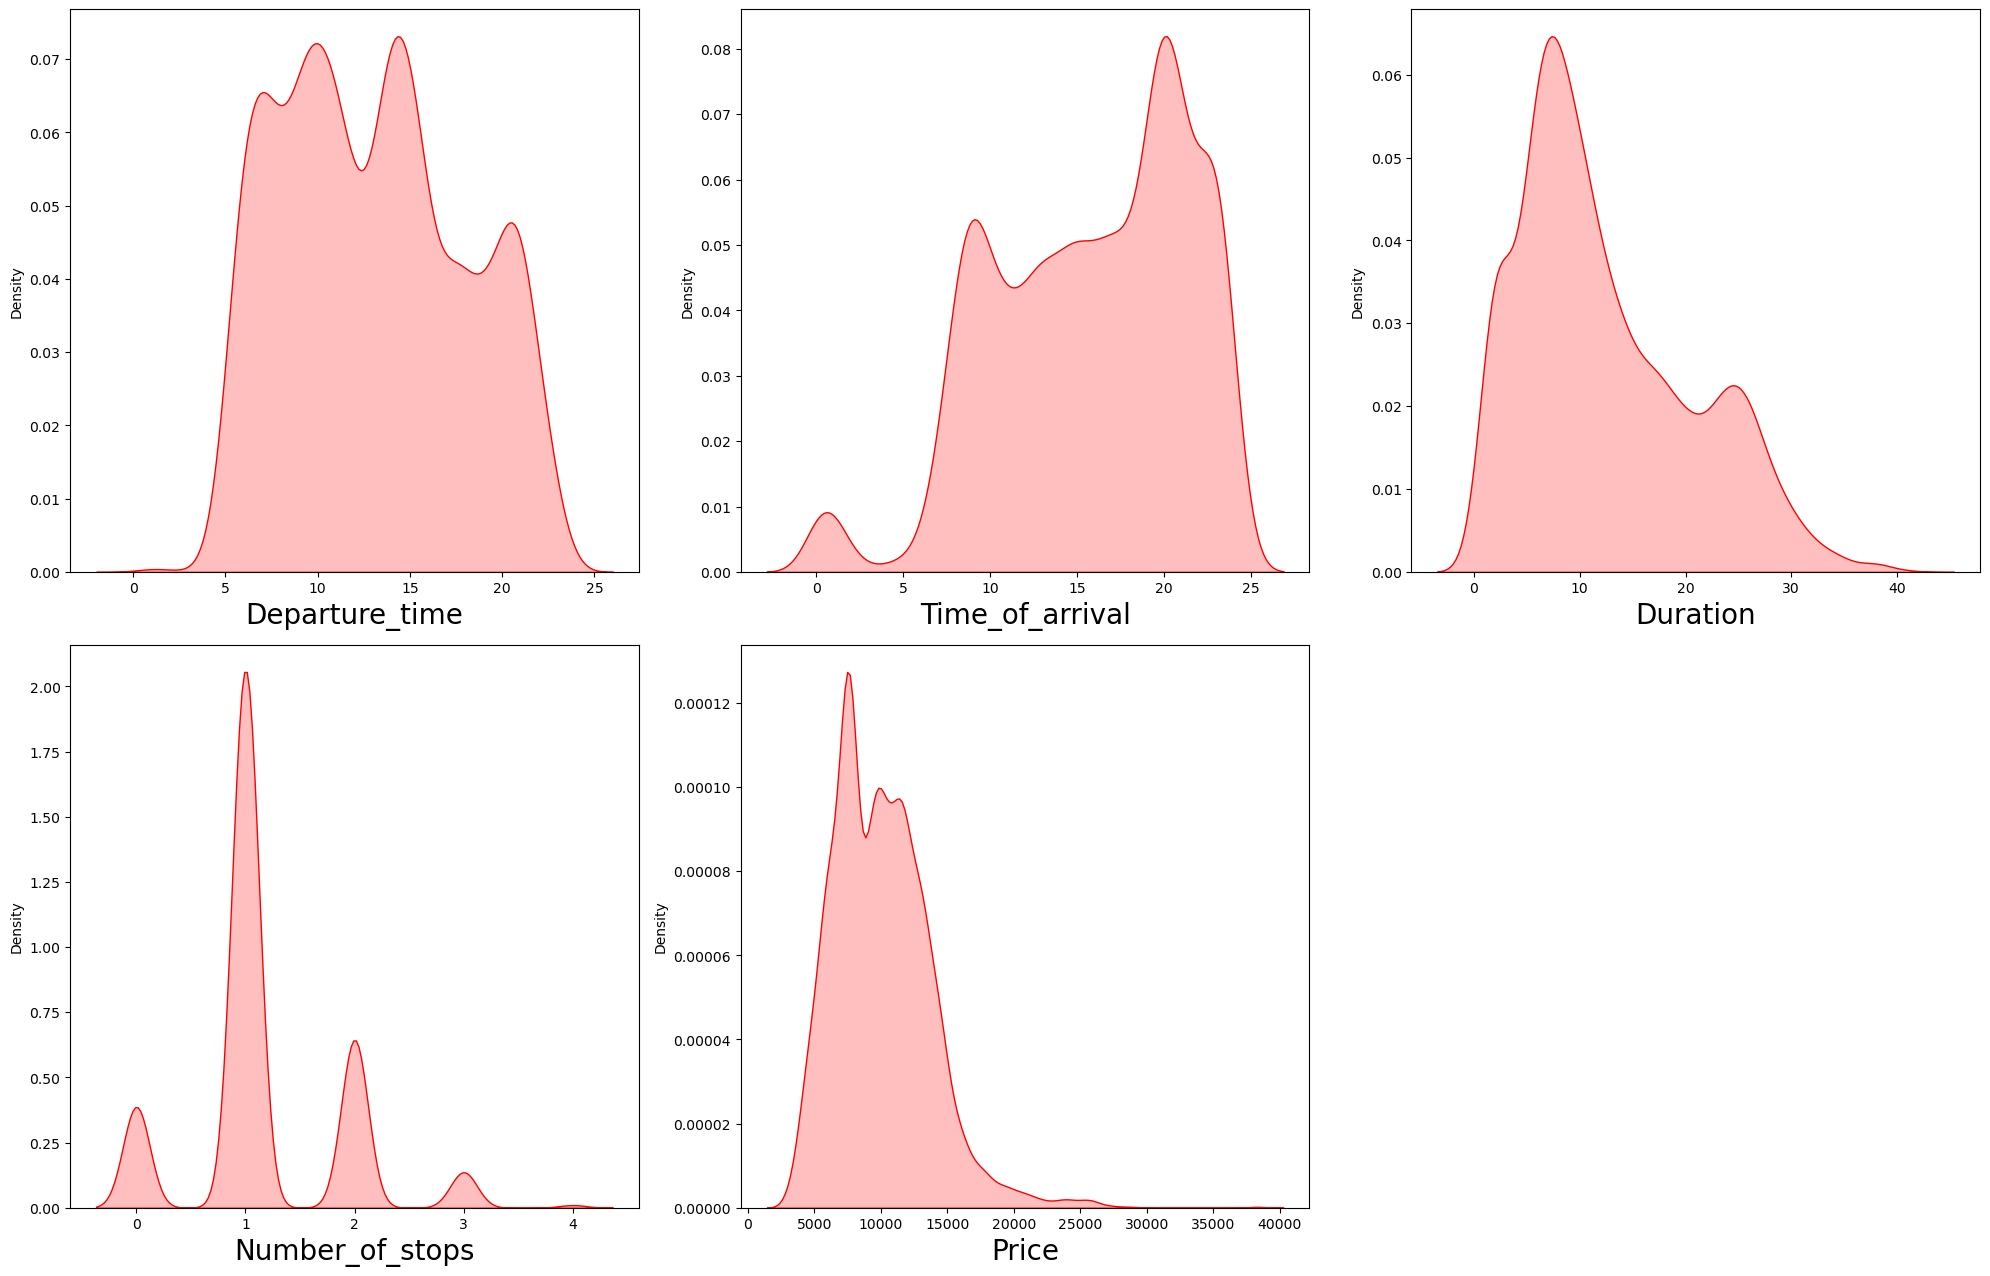

In [31]:
#Lets have a look on distribution of our data
num_data = df._get_numeric_data()
plt.style.use('default')
plt.figure(figsize = (20,25))
plotnumber = 1
for column in num_data:
    if plotnumber <=12:
        ax = plt.subplot(4,3,plotnumber)
        sns.distplot(num_data[column],hist=False, color="red", kde_kws={"shade": True})
        plt.xlabel(column,fontsize = 20)
    plotnumber+=1
plt.tight_layout()


### Outliers:

In [32]:
# Now checking for numerical columns
numerical_columns=[]
for i in df.dtypes.index:
    if df.dtypes[i]!='object':
        numerical_columns.append(i)
print(numerical_columns)

['Departure_time', 'Time_of_arrival', 'Duration', 'Number_of_stops', 'Price']


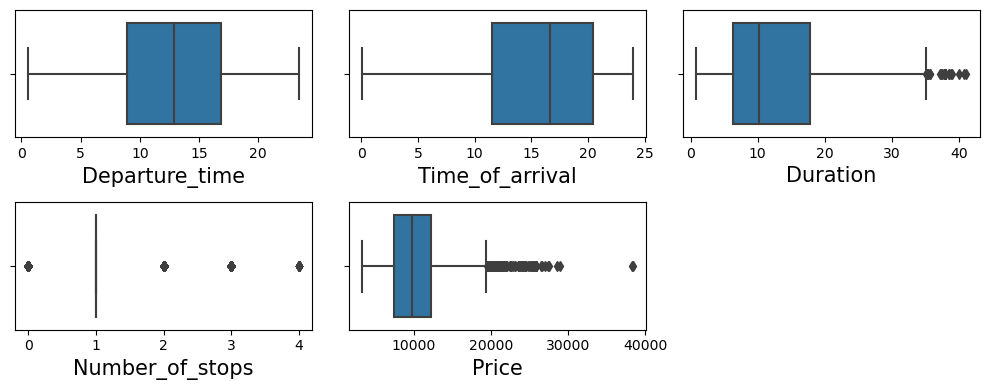

In [33]:
# Checking if the outliers is reduced or not

plt.figure(figsize=(10,4),facecolor='white')
plotnumber=1
for column in numerical_columns:
    if plotnumber<=30:
        ax=plt.subplot(2,3,plotnumber)
        sns.boxplot(df[column])
        plt.xlabel(column,fontsize=15)
    plotnumber+=1
plt.tight_layout()

Looking at the distribution of these features we can say the Duration column is having some outliers so I will remove outliers only from this column

In [34]:
df.shape

(5805, 9)

In [35]:
#apply zscore to remove outliers
from scipy import stats
from scipy.stats import zscore
z_score = zscore(df[['Duration']])
abs_z_score = np.abs(z_score)
filtering_entry = (abs_z_score < 3).all(axis = 1)
df = df[filtering_entry]
df.shape

(5783, 9)

In [36]:
#Checking dataloss in zscore method
Dataloss = (((5805-5783)/5805)*100)
print("Dataloss:",Dataloss,"%")

Dataloss: 0.3789836347975883 %


Here by removing outliers from our data we are not loosing much data.

### Encoding

In [37]:
#lets convert categorical data into numeric values, using OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
for i in df.columns:
    if df[i].dtypes == "object" :
        df[i] = enc.fit_transform(df[i].values.reshape(-1,1))

In [38]:
df

,Airline,Departure_time,Time_of_arrival,Duration,Source,Destination,Meal_availability,Number_of_stops,Price
0,0.0,12.666667,20.250000,7.583333,8.0,7.0,1.0,1,5953.0
1,0.0,11.916667,20.250000,8.333333,8.0,7.0,1.0,1,5953.0
2,0.0,16.250000,6.333333,14.083333,8.0,7.0,1.0,1,5953.0
3,2.0,18.833333,20.750000,1.916667,8.0,7.0,1.0,0,5954.0
4,2.0,9.083333,11.083333,2.000000,8.0,7.0,1.0,0,5954.0
...,...,...,...,...,...,...,...,...,...
5800,1.0,8.916667,8.333333,23.416667,6.0,4.0,1.0,1,9302.0
5801,1.0,8.916667,9.333333,24.416667,6.0,4.0,1.0,2,16287.0
5802,1.0,14.750000,9.333333,18.583333,6.0,4.0,1.0,2,16865.0
5803,1.0,8.916667,9.333333,24.416667,6.0,4.0,1.0,2,16865.0


In [39]:
df.describe()

,Airline,Departure_time,Time_of_arrival,Duration,Source,Destination,Meal_availability,Number_of_stops,Price
count,5783.000000,5783.000000,5783.000000,5783.000000,5783.000000,5783.000000,5783.000000,5783.000000,5783.000000
mean,2.797856,13.049210,15.804441,12.354401,4.107211,4.017811,0.918036,1.168252,10037.510980
std,1.603065,4.879733,5.544498,7.995059,2.699768,2.722911,0.511566,0.692562,3670.376586
min,0.000000,0.583333,0.083333,0.833333,0.000000,0.000000,0.000000,0.000000,3361.000000
25%,1.000000,9.000000,11.375000,6.333333,2.000000,2.000000,1.000000,1.000000,7425.000000
50%,3.000000,13.000000,16.583333,10.166667,4.000000,4.000000,1.000000,1.000000,9721.000000
75%,5.000000,16.833333,20.416667,17.750000,7.000000,7.000000,1.000000,1.000000,12246.000000
max,5.000000,23.416667,23.916667,35.666667,8.000000,8.000000,2.000000,4.000000,38348.000000


## Heat map for checking correlation

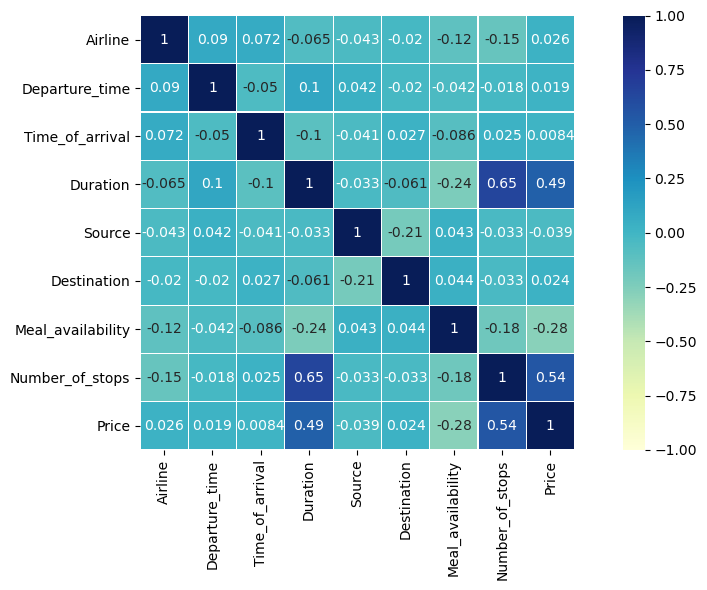

In [40]:
#Lets plot heatmap to check correlation among differnt features and label
df_corr = df.corr()
plt.figure(figsize = (10,6))
sns.heatmap(df_corr,vmin=-1,vmax=1,annot=True,square=True,center=0,fmt='.2g',linewidths=0.1, cmap="YlGnBu")
plt.tight_layout()

* This heat map is showing the correlation among different features. 
* Looking at this plot we can conclude that the features like Duration, Meal_availability and Number_of_stops are having more correlation with our target column.
* Rest of the features are having very less correlation with the target column.
* It is obvious that feature Duration & Meal_availability having more correlation.

In [41]:
#lets check the skewness
df.skew()

Airline              0.090947
Departure_time       0.210466
Time_of_arrival     -0.540242
Duration             0.687470
Source              -0.071056
Destination         -0.020033
Meal_availability   -0.127606
Number_of_stops      0.719591
Price                1.062043
dtype: float64

In [42]:
#I will shuffle our data for getting good result while evaluating
df = df.sample(frac = 1)
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace = True)

In [43]:
df

,Airline,Departure_time,Time_of_arrival,Duration,Source,Destination,Meal_availability,Number_of_stops,Price
0,3.0,5.416667,12.416667,7.000000,1.0,7.0,1.0,1,8323.0
1,2.0,8.833333,19.916667,11.083333,6.0,5.0,2.0,1,5152.0
2,3.0,13.916667,21.416667,7.500000,6.0,3.0,1.0,1,11852.0
3,3.0,13.916667,19.083333,5.166667,6.0,4.0,1.0,1,4366.0
4,1.0,16.916667,10.250000,17.333333,5.0,8.0,0.0,1,24129.0
...,...,...,...,...,...,...,...,...,...
5778,3.0,7.750000,9.000000,1.250000,0.0,2.0,1.0,0,4968.0
5779,5.0,13.333333,9.250000,19.916667,2.0,5.0,1.0,2,10049.0
5780,0.0,8.750000,16.583333,7.833333,5.0,7.0,1.0,1,7696.0
5781,1.0,6.166667,23.416667,17.250000,0.0,7.0,1.0,2,12470.0


## Saperate features and label as x and y respectively

In [44]:
x = df.drop(columns = 'Price')
y = df['Price']

In [45]:
#lets check skewness
x.skew()

Airline              0.090947
Departure_time       0.210466
Time_of_arrival     -0.540242
Duration             0.687470
Source              -0.071056
Destination         -0.020033
Meal_availability   -0.127606
Number_of_stops      0.719591
dtype: float64

In [46]:
#Lets treat the skewness
for index in x.skew().index:
    if x.skew().loc[index]>0.5:
        x[index]=np.log1p(x[index])
        if x.skew().loc[index]<-0.5:
            x[index]=np.square(x[index])

In [47]:
#lets check skewness again
x.skew()

Airline              0.090947
Departure_time       0.210466
Time_of_arrival     -0.540242
Duration            -0.465044
Source              -0.071056
Destination         -0.020033
Meal_availability   -0.127606
Number_of_stops      1.224965
dtype: float64

### Applying StandardScaler to numerical features

In [48]:
#lets apply standard scaler to numerical features to bring them to common scale
numeric = ['Departure_time','Time_of_arrival','Duration']
categorical = ['Airline','Source','Destination','Meal_availability','Number_of_stops']
scaler = StandardScaler()
X_numeric_std = pd.DataFrame(data=scaler.fit_transform(x[numeric]), columns=numeric)
X_std = pd.merge(X_numeric_std, x[categorical], left_index=True, right_index=True)

In [49]:
X_std

,Departure_time,Time_of_arrival,Duration,Airline,Source,Destination,Meal_availability,Number_of_stops
0,-1.564267,-0.611068,-0.455977,3.0,1.0,7.0,1.0,0.480453
1,-0.864031,0.741741,0.152795,2.0,6.0,5.0,2.0,0.480453
2,0.177783,1.012303,-0.366482,3.0,6.0,3.0,1.0,0.480453
3,0.177783,0.591429,-0.840213,3.0,6.0,4.0,1.0,0.480453
4,0.792623,-1.001880,0.768222,1.0,5.0,8.0,0.0,0.480453
...,...,...,...,...,...,...,...,...
5778,-1.086057,-1.227348,-2.328580,3.0,0.0,2.0,1.0,0.000000
5779,0.058230,-1.182254,0.962826,5.0,2.0,5.0,1.0,1.206949
5780,-0.881110,0.140492,-0.309697,0.0,5.0,7.0,1.0,0.480453
5781,-1.410556,1.373052,0.761497,1.0,0.0,7.0,1.0,1.206949


### Applying log transformation to our target variable

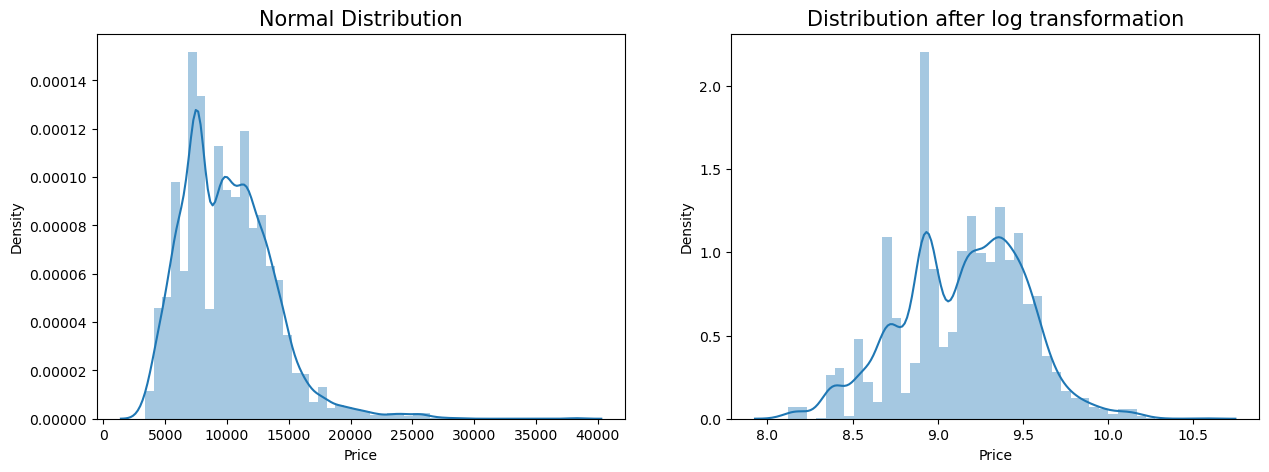

In [50]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Normal Distribution",fontsize=15)
sns.distplot(y)
plt.subplot(1,2,2)
plt.title("Distribution after log transformation",fontsize=15)
sns.distplot(np.log(y))
plt.show()

As we can see our target variable is right skewed thats why I will apply log transfomation to it for better results.

## Finding Best random_state

In [51]:
#to find random stat which gives maximum r2_score
from sklearn.linear_model import LinearRegression
max_r_score=0
r_state = 0
for i in range(1,500):
    x_train, x_test, y_train, y_test = train_test_split(X_std, np.log(y),test_size = 0.25,random_state = r_state)
    reg = LinearRegression()
    reg.fit(x_train,y_train)
    y_pred = reg.predict(x_test)
    r2_scr=r2_score(y_test,y_pred)
    if r2_scr > max_r_score:
        max_r_score = r2_scr
        r_state = i
print("max r2 score is",max_r_score,"on Random State",r_state)

max r2 score is 0.4648893579569382 on Random State 4


## Model Building With Evaluation

In [52]:
#lets split our train data into train and test part
x_train, x_test, y_train, y_test = train_test_split(x, np.log(y),test_size = 0.25, random_state = r_state)

In [53]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor()
ext = ExtraTreesRegressor()
lgb = LGBMRegressor()
lasso = LassoCV(max_iter=1000, normalize = True)
ridge = RidgeCV(cv=10,alphas=[0.1,1], normalize=True)

In [54]:
#creating a function to train and test the model with evaluation
def BuiltModel(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    pred = model.predict(x_test)

    r2score = r2_score(y_test,pred)*100

    #evaluation
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test,pred)
    print("MAE :", mae)
    print("RMSE :", rmse)
    print('------------------------------')

    # r2 score
    print(f"Training r2 score:", r2_score(y_train,y_pred)*100,"%")
    print(f"Testing r2 Score:", r2score,"%")
    print('------------------------------')

    #cross validation score
    scores = cross_val_score(model, X_std, np.log(y), cv = 10).mean()*100
    print("\nCross validation score :", scores)

    #result of accuracy minus cv score
    result = r2score - scores
    print("\nAccuracy Score - Cross Validation Score :", result)

    sns.regplot(y_test,pred,line_kws={'color': 'gold'})
    plt.show()    

******************************LinearRegression******************************
MAE : 0.2156878488305724
RMSE : 0.2790841851428539
------------------------------
Training r2 score: 44.912640156947035 %
Testing r2 Score: 43.506927283512894 %
------------------------------

Cross validation score : 44.22036851050555

Accuracy Score - Cross Validation Score : -0.7134412269926571


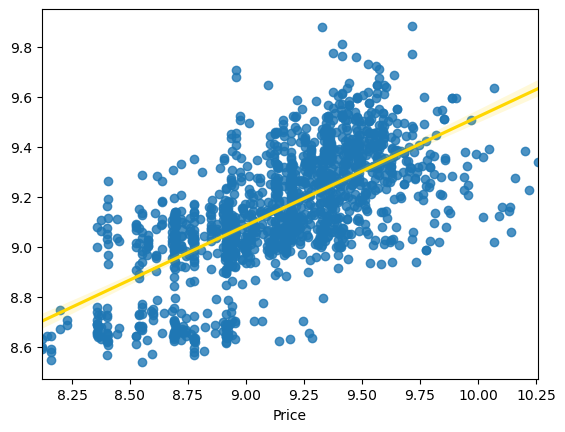

******************************LassoCV******************************
MAE : 0.21565837511175084
RMSE : 0.2790702293838236
------------------------------
Training r2 score: 44.912344681091234 %
Testing r2 Score: 43.51257707694012 %
------------------------------

Cross validation score : 44.22009691923285

Accuracy Score - Cross Validation Score : -0.7075198422927329


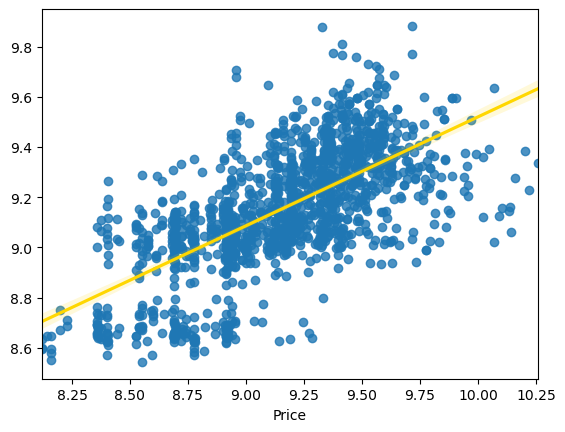

******************************RidgeCV******************************
MAE : 0.2156356672286315
RMSE : 0.2794915194472356
------------------------------
Training r2 score: 44.75176278797134 %
Testing r2 Score: 43.34189923215936 %
------------------------------

Cross validation score : 44.07837151330637

Accuracy Score - Cross Validation Score : -0.7364722811470088


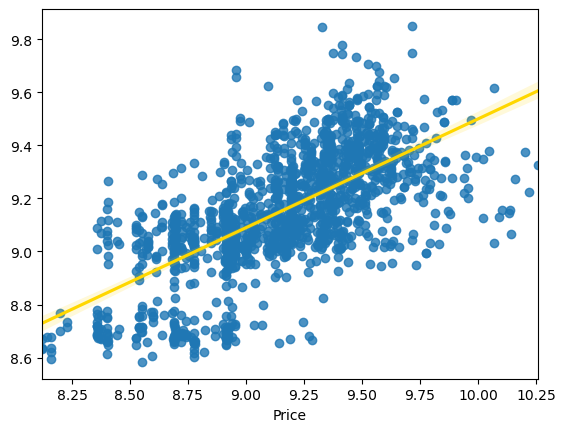

******************************DecisionTreeRegressor******************************
MAE : 0.13879209920802676
RMSE : 0.24458881711228878
------------------------------
Training r2 score: 99.89557255900066 %
Testing r2 Score: 56.609172113245606 %
------------------------------

Cross validation score : 55.48325065362456

Accuracy Score - Cross Validation Score : 1.125921459621047


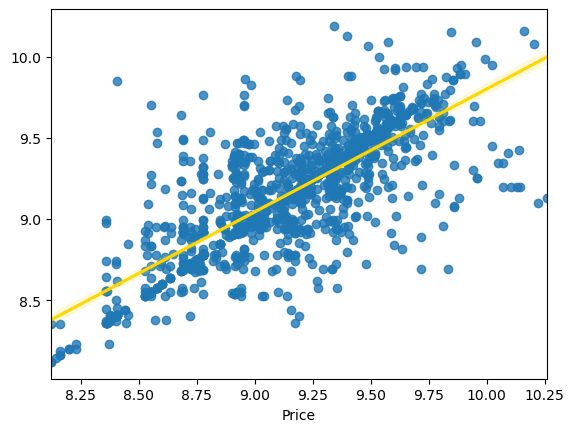

******************************RandomForestRegressor******************************
MAE : 0.12192026967474061
RMSE : 0.18782778973810454
------------------------------
Training r2 score: 96.17051945383098 %
Testing r2 Score: 74.41152293480069 %
------------------------------

Cross validation score : 74.9750970670924

Accuracy Score - Cross Validation Score : -0.5635741322917198


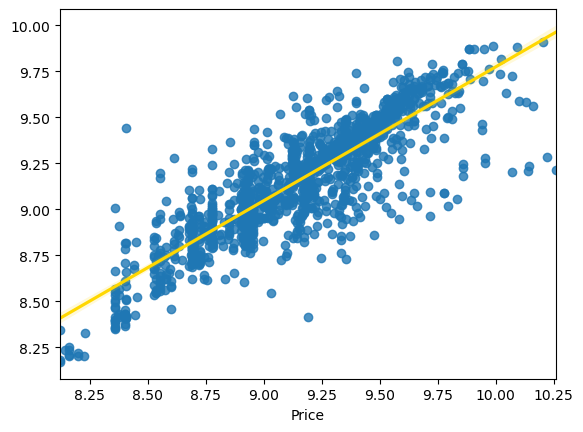

******************************XGBRegressor******************************
MAE : 0.12837566013708823
RMSE : 0.18344865443297984
------------------------------
Training r2 score: 93.97060311129904 %
Testing r2 Score: 75.59078547497916 %
------------------------------

Cross validation score : 75.02133378497477

Accuracy Score - Cross Validation Score : 0.5694516900043851


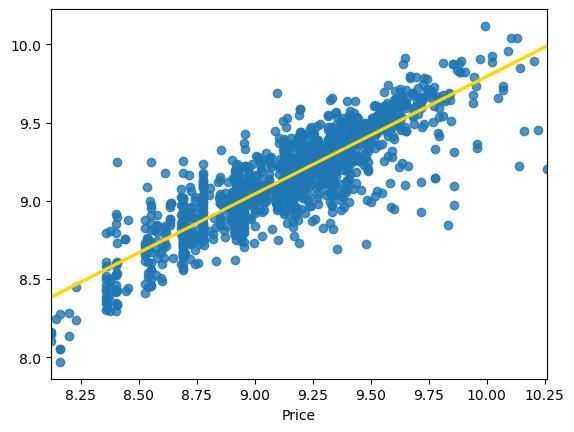

******************************ExtraTreesRegressor******************************
MAE : 0.11551351381798469
RMSE : 0.18715430981937284
------------------------------
Training r2 score: 99.89557255900066 %
Testing r2 Score: 74.59469529030372 %
------------------------------

Cross validation score : 75.33027521438815

Accuracy Score - Cross Validation Score : -0.7355799240844334


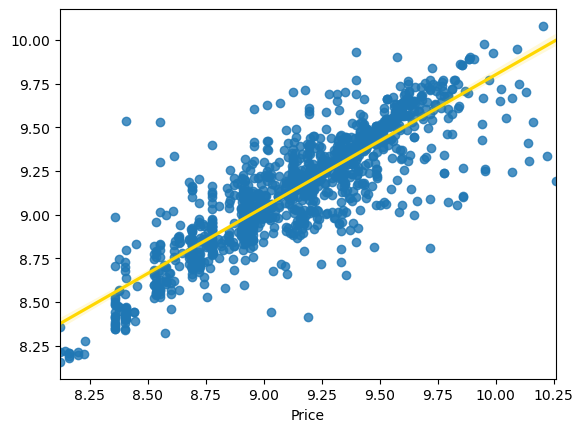

******************************LGBMRegressor******************************
MAE : 0.13737129500528303
RMSE : 0.19448037934625445
------------------------------
Training r2 score: 82.26615251244694 %
Testing r2 Score: 72.56680889064715 %
------------------------------

Cross validation score : 72.80237537333475

Accuracy Score - Cross Validation Score : -0.23556648268760227


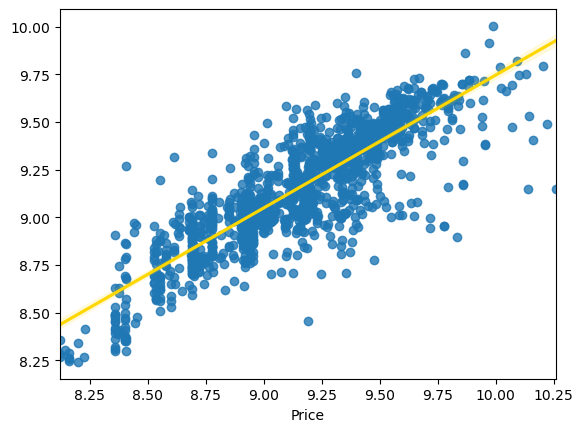

In [55]:
for model in [lr,lasso,ridge,dt,rf,xgb,ext,lgb]:
    BuiltModel(model)

In this project due to less features and simplisity our model may lead to over-fitting. We can observe Linear models showing very less accuracy, I will prefer to chose tree related algorithms among which LGBMRegressor is giving me less difference in r2-score and cv-score so i will select LGBMRegressor as a best suitable algorithm for our final model.

## Hyperparameter Tuning

In [56]:
#lets selects different parameters for tuning
grid_params = {
                'boosting_type': ['str','gbdt'],
                'max_depth ':[-1,-0.5],
                'learning_rate': [0.1,0.2,0.3],
                'n_estimators':[800,900,1000]
                }

In [57]:
#train the model with given parameters using GridSearchCV
GCV =  GridSearchCV(LGBMRegressor(), grid_params,verbose=1,refit=True,n_jobs=-1, cv = 5)
GCV.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: -1


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['str', 'gbdt'],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth ': [-1, -0.5],
                         'n_estimators': [800, 900, 1000]},
             verbose=1)

In [58]:
GCV.best_params_       #printing the best parameters found by GridSearchCV

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth ': -1,
 'n_estimators': 800}

## Final Model

In [59]:
#lets train and test our final model with best parameters
model = LGBMRegressor(boosting_type = 'gbdt',
                      learning_rate = 0.1,
                      n_estimators = 800,
                      max_depth=-1)

model.fit(x_train,y_train)
pred = model.predict(x_test)

r2score = r2_score(y_test,pred)*100

#evaluation
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,pred)
print("MAE :", mae)
print("RMSE :", rmse)
print('------------------------------')

# r2 score

print(f" \nr2 Score:", r2score,"%")

MAE : 0.12700025773946114
RMSE : 0.18493538527362255
------------------------------
 
r2 Score: 75.1935409688982 %


Great we have achieved a better r2 score after doing hyperparameter tuning than earlier.

#### lets see the Predicted vs Actual data points

In [60]:
prediction = np.exp(pred)

In [61]:
prediction

array([ 8427.86222137,  6071.53150606, 12771.76359448, ...,
        8611.61757926,  7920.556677  , 11330.47432547])

In [62]:
pd.DataFrame([model.predict(x_test)[:],y_test[:]],index=["Predicted","Actual"])

,0,1,2,3,4,5,6,7,8,9,...,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445
Predicted,9.039298,8.711366,9.454992,8.354833,9.716429,9.209026,9.257754,9.283212,9.118538,9.299848,...,9.545605,9.035110,8.532868,9.226145,9.486681,9.096743,9.217153,9.060867,8.977217,9.335251
Actual,8.899185,8.691986,9.440817,8.401333,9.715228,9.127067,9.124565,9.215228,8.884056,9.395325,...,9.589598,8.691986,8.689969,9.135293,9.474703,9.431883,9.120525,8.939319,8.920923,9.355911


#### Lets see the graph for actual vs predicted values

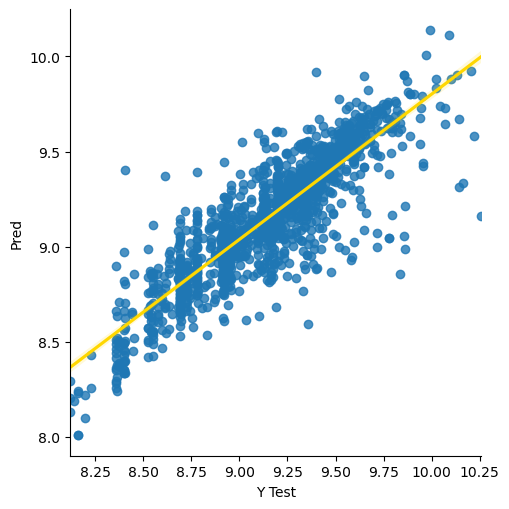

In [63]:
data = pd.DataFrame({'Y Test':y_test , 'Pred':pred},columns=['Y Test','Pred'])
sns.lmplot(x='Y Test',y='Pred',data=data, line_kws={'color': 'gold'})
plt.show()

## Model Saving

In [64]:
import joblib
joblib.dump(model,"FlightPrice_prediction.pkl")

['FlightPrice_prediction.pkl']

## Conclusion:
* In this project we have scraped the flight data from yatra.com. Then the csv file is loaded into a dataframe.
* Luckily we don't have any missing values in our data set.
* Looking at the data set we understand that there are some features needs to be processed like converting the data types, and get the actual value from the string entries from the time related columns.
* After the data is been processed I have done some EDA to understand the relation among features and the target variable.
* Features like flight duration, number of stops during the journey and the availability of meals are playing major role in predicting the prices of the flights

* As looking at the features we came to know that the number of features are very less, due to which we are getting somewhat lower r2-scores.
* some algorithms are facing over-fitting problem which may be because of less number of features in our dataset.
* We can get a better r2 score than now by fetching some more features from the web scraping by that we may also reduce the over fitting problem in our models.
